In [1]:
# Import packages

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

# Load the data
df = pd.read_csv("UsArrests.csv")
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [2]:
# "This data set contains statistics, in arrests per 100,000 residents, for assault, murder, and rape in each of the 50 US states in 1973.
# Also given is the percent of the population living in urban areas."

In [3]:
# DATA CLEANING - PRE PROCESSING

# Index column is called City when it should be State

#df = df.rename(columns = {'City':'State'}, inplace = True, axis=1)

df.rename({'City':'State'}, axis=1, inplace=True)

df.head()


,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [4]:
# Shape of the data
print('Number of cases: {} Number of features: {}'.format(df.shape[0],df.shape[1]))

Number of cases: 50 Number of features: 5


In [5]:
# Summary statistics

stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() 
selected_stats

# Assualt has the largest mean, which makes sense as its a broader term and could cover lots of less severe crimes.
# UrbanPop is a percentage, whereas the other three variables are out of 100,000. Differing scales.

,mean,std,min,max
Murder,7.788,4.355510,0.8,17.4
Assault,170.760,83.337661,45.0,337.0
UrbanPop,65.540,14.474763,32.0,91.0
Rape,21.232,9.366385,7.3,46.0


In [6]:
# Count missing values
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

# No missing data.

,missing
State,0
Murder,0
Assault,0
UrbanPop,0
Rape,0


In [7]:
# Examine data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   State     50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


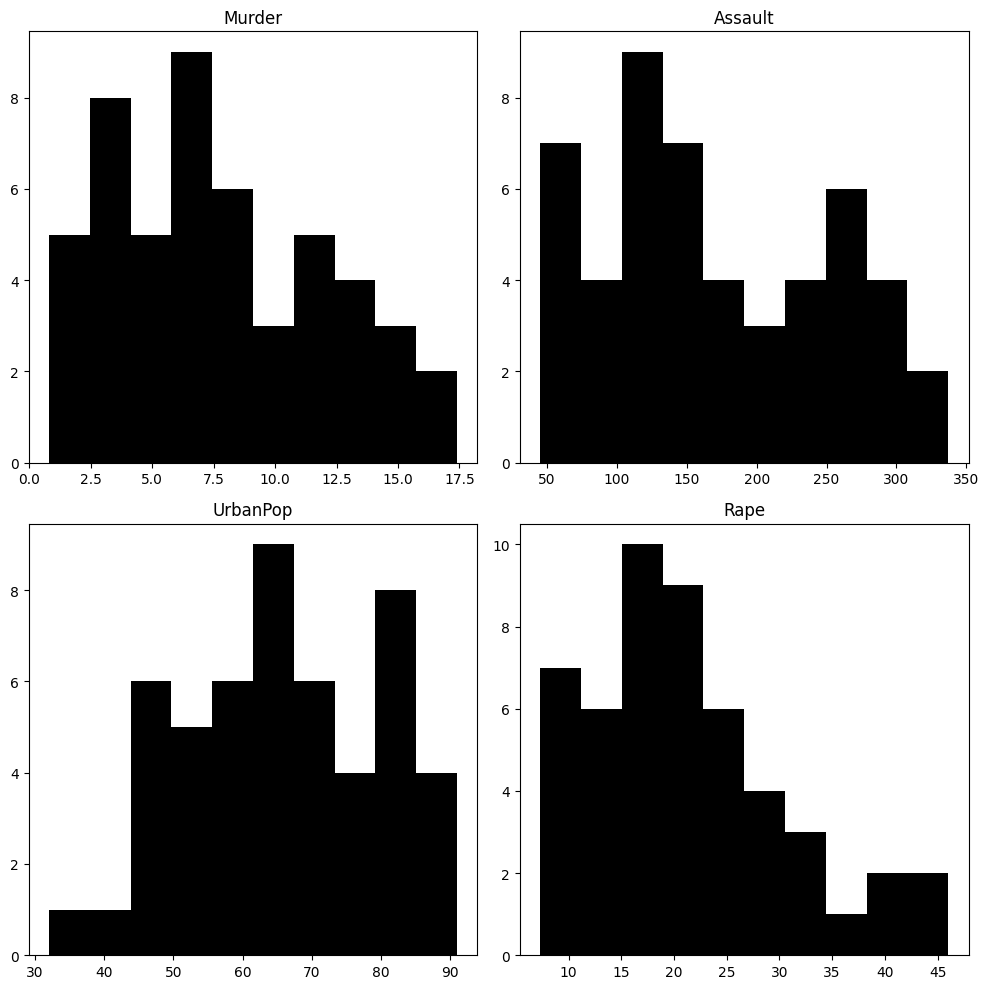

In [8]:
# DATA ANALYSIS

# To get a sense of the distributions of the data, here are the histograms
histograms = df.hist(color='black', grid=False, figsize=(10, 10)) 
plt.tight_layout()
plt.show()

<AxesSubplot: >

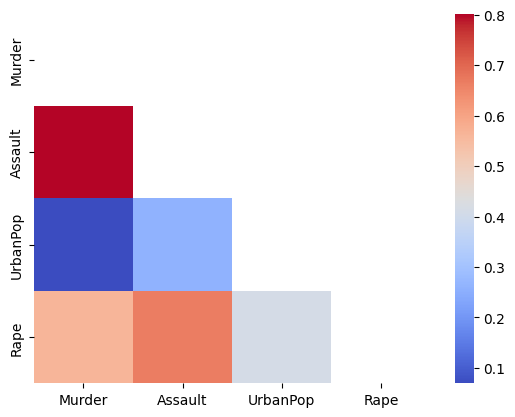

In [9]:
# Get a sense of how the data is correlated
# Correlation heatmap

states = df.index
corr_df = df.drop(["State"],axis=1).corr()
labels =corr_df.columns

mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm")

# We can see there is a very strong positive correlation between assualt and murder.
# There is also a strong positive correlation between assualt and rape.
# Urban pop and murder seems to have no correlation.
# Murder and rape has a positive correlation

In [10]:
# Principal Component Analysis (PCA)

np.set_printoptions(precision=2)

X = df.drop(["State"],axis=1).values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.802164,11.448007,-2.494933,2.407901
1,92.827450,17.982943,20.126575,-4.094047
2,124.068216,-8.830403,-1.687448,-4.353685
3,18.340035,16.703911,0.210189,-0.520994
4,107.422953,-22.520070,6.745873,-2.811826


In [11]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [83.73 14.21  6.49  2.48]


In [12]:
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [9.66e-01 2.78e-02 5.80e-03 8.49e-04]


In [13]:
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Cumulative Proportion: [7011.11 7213.11 7255.22 7261.38]


In [14]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = states[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

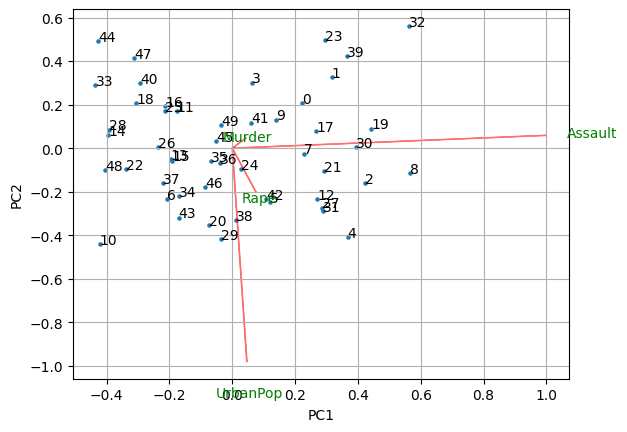

In [15]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(states))
plt.show()

# The importance of each feature is indicated by the length of the red lines. This corresponds to the magnitude of the values in the eigenvectors.
# We can see that assualt and urban population are the most important features.

In [16]:
# Lets check out the feature importance in a table which confirms what was said above.

pd.set_option('display.float_format', lambda x: '%.3f' % x)

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

# We can see that assualt has a score of 0.995 in PC1 and Urban Pop has a score of 0.977 in PC2.
# We know that the data set works out the Urban Pop as a percentage whereas the other variables are out of 100,000. 
# This may require standarising to avoid certain features 'swamping' others.

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


In [17]:
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


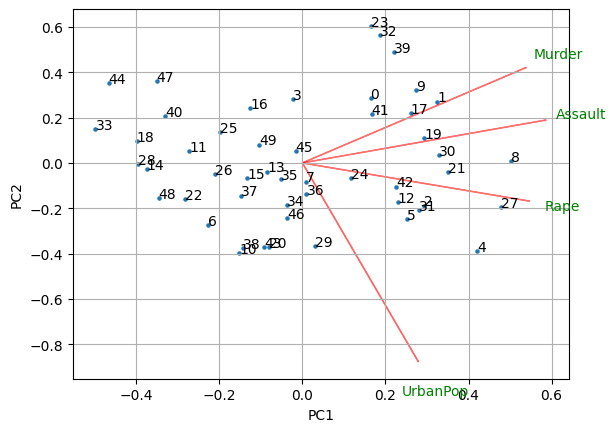

In [18]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

# After standardising we can see that all four variables appear to explain the variance. There isn't a clear dominant feature.
# We can also see that the three crimes are closer together (forming a cluster) whilst urban pop is separate. 

In [19]:
# Feature importance

pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

# Now we can see under PC1, that the three types of crime have fairly similar importance, with assault being slightly higher.
# Urban pop is very high compared to the crimes under PC2. With murder being higher than assualt and rape.

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


Text(0.5, 1.0, 'Cumulative Explained Variance')

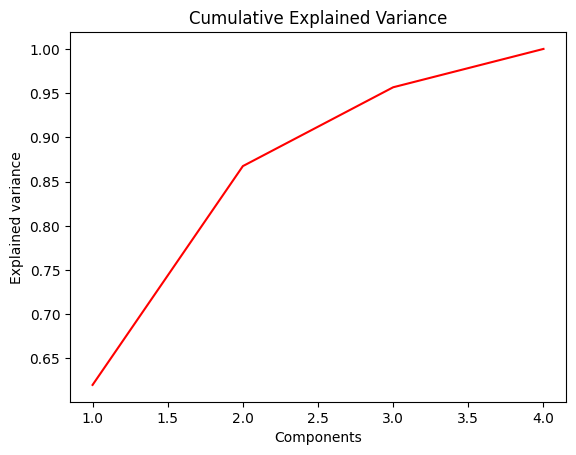

In [20]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

# The first 3 components together explain over 90% of the variance. We can do some dimension reduction to perform cluster analysis.

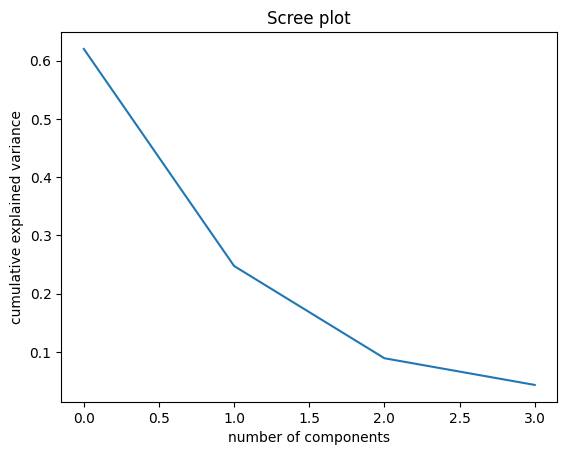

In [21]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

In [22]:
pca_df = pd.DataFrame(X_std_trans[:,0:3], index = df.index)
pca_df.head()

,0,1,2
0,0.986,1.133,-0.444
1,1.950,1.073,2.040
2,1.763,-0.746,0.055
3,-0.141,1.120,0.115
4,2.524,-1.543,0.599


In [23]:
# Hierarchical clustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

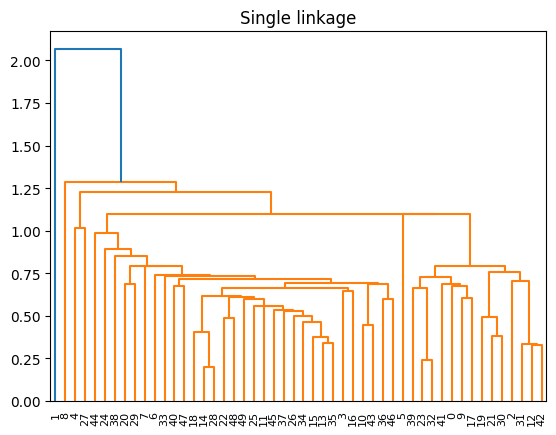

In [24]:
plt.title("Single linkage")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index)
plt.show()

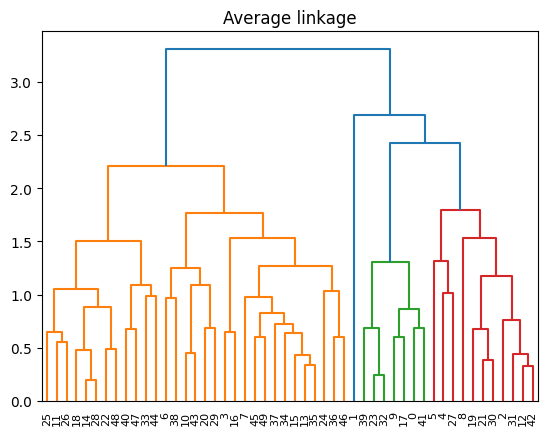

In [25]:
plt.title("Average linkage")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index)
plt.show()

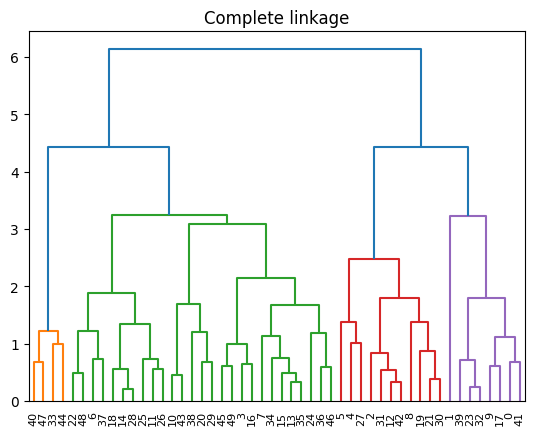

In [26]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

c:\Users\samwilson\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


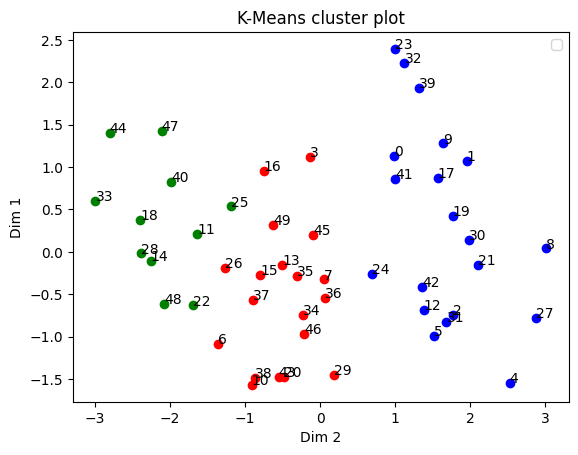

In [27]:
# K means clustering
# K will be set to 3

# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=3
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = states[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

In [28]:
# Groups - translate to readable names
clusters = pd.DataFrame()

group0_indices = np.argwhere(cluster_labels==0).transpose()[0]
group1_indices = np.argwhere(cluster_labels==1).transpose()[0]
group2_indices = np.argwhere(cluster_labels==2).transpose()[0]

group0 = np.array(states)[group0_indices]
group1 = np.array(states)[group1_indices]
group2 = np.array(states)[group2_indices]


print("Group 0: {}\n\n".format([df.loc[x]["State"] for x in group0]))
print("Group 1: {}\n\n".format([df.loc[x]["State"] for x in group1]))
print("Group 2: {}\n\n".format([df.loc[x]["State"] for x in group2]))

# I don't know enough about US states to see any patterns or meaningful insights in the groups below.

Group 0: ['Arkansas', 'Connecticut', 'Delaware', 'Hawaii', 'Indiana', 'Kansas', 'Kentucky', 'Massachusetts', 'Nebraska', 'New Jersey', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'Utah', 'Virginia', 'Washington', 'Wyoming']


Group 1: ['Alabama', 'Alaska', 'Arizona', 'California', 'Colorado', 'Florida', 'Georgia', 'Illinois', 'Louisiana', 'Maryland', 'Michigan', 'Mississippi', 'Missouri', 'Nevada', 'New Mexico', 'New York', 'North Carolina', 'South Carolina', 'Tennessee', 'Texas']


Group 2: ['Idaho', 'Iowa', 'Maine', 'Minnesota', 'Montana', 'New Hampshire', 'North Dakota', 'South Dakota', 'Vermont', 'West Virginia', 'Wisconsin']


